#### Imports

In [1]:
# Show all Jupyter cell outputs, NOT just the last cell's output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import re
import string
from random import randint

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, recall_score, precision_score,f1_score


#### 1. Reading Data from Excel 
#### 2. Label Encoding the Classes

In [2]:
# Use pandas to pluck out abstracts
posts = pd.read_excel('PostClassification.xlsx')


In [3]:
posts['Xs'] =  posts.title +' '+ posts.content #creat new column 'Xs'
posts['Y'] = LabelEncoder().fit(posts.Class.unique()).transform(posts.Class) #label encode

posts = posts[['Xs','Y','Class']] # Drop 'title' and 'content'

In [4]:
#inspect the dataframe
posts.columns
posts.sample(5)

Index(['Xs', 'Y', 'Class'], dtype='object')

,Xs,Y,Class
3888,Desist from vengeful retribution : Emmerson Mn...,5,Politics
117,ZESCO owes Mozambican Power Company Over Us$5...,0,Business
2778,M’membe Joins Politics Defunct Post Newspaper...,5,Politics
461,Media owners to engage IBA over Prime TV suspe...,5,Politics
6244,T.B. Joshua declares his intentions to leave N...,6,Religion


In [5]:

post_content = posts.Xs
print('There are a total of {} posts'.format(len(post_content)))

index = randint(0,20)  #only inspect posts from the first 20 in the list
post_content[index]

There are a total of 6256 posts


'GBM has joined PF’s focus on fixing HH instead of national problems  Katuka UPND secretary general Steven Katuka says the party has noted with disbelief the continued focus by former party vice president GBM and PF secretary general Davies Mwila on insulting UPND leader Hakainde Hichilema at the expense of finding solutions to national development.In a statement, Katuka said his party was more focused on finding solutions to national challenges than personal attacks.“We have noted media reports widely quoting PF Secretary General Davies Mwila while others are quoting our former vice-President Geoffrey Bwalya Mwamba, now a PF member, all saying they want to dismantle the UPND and fix our party President Hakainde Hichilema. We hope our citizens, especially the youth and women, are all seeing what matters the most to the PF officials as opposed to development, education and health,” Katuka said.“President Hichilema gave a very respectable and dignified message of farewell to the former V

#### Viewing the post distribution in relation to Classes

Class
Business         1406
Education         321
Entertainment     368
Health            289
Lifestyle         800
Politics         1986
Religion          256
Sports            830
Name: Class, dtype: int64

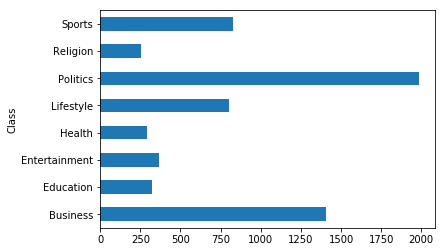

In [6]:
#inspecting the distribution of comments
posts.groupby('Class').Class.count()
posts.groupby('Class').Class.count().plot.barh()

#### Cleaning the posts
##### 1. drop NaN records
##### 2. make all words into lower case
##### 3. remove punctuations and numbers
##### 4. remove stopwords
##### 5. stemming

In [7]:

# 2. Case Folding
# Good idea to implement a function here [...]

def func_post_case_folding(contentText):
    return contentText.lower()

# 3. Punctuation
# Function for removing punctuations from string of text
def func_post_punctuation(contentText):
    
    #replace special charactors with ' '
    contentText_out = re.sub('[^\w\s]', ' ',contentText)
    contentText_out = re.sub('_', '',contentText_out)
    
    #change any whitespace to one space
    contentText_out = re.sub('\s+', ' ',contentText_out)
    
    #remove start and end whitespaces
    contentText_out = contentText_out.strip()
    
    contentText_out = re.sub('\w*\d\w*', '', contentText_out) # replace digits
    return contentText_out

# 4. Stopwords
# Function for removing stopwords from string of text
def func_post_stopwords(contentText_in):
    
    contentText_out = " ".join([
        contentText_word for contentText_word in contentText_in.split() 
        if contentText_word not in stopwords.words('english')
    ])
    return contentText_out

# 5. Stemming
# Function for removing stopwords from string of text
# Remember: input will be chunck of text
def func_post_stem(contentText):
    var_stemmer = PorterStemmer()
    contentText_out = " ".join([
        var_stemmer.stem(contentText_word) for contentText_word in contentText.split() 
    ])
    return contentText_out

# 6. form the corpus

def func_get_all_words(content_list):
    all_words = []
    for item in content_list:
        for n in item.split():
            all_words.append(n)
    return all_words
        

# 7. Term Frequency 

def func_tf_transform(all_words_list,clean_content_list):
    var_transformed_dataset = []
    for item in clean_content_list:
        #print (var_etd_entry)
        var_dataset = []
        var_tokens = item.split()
        for x in all_words_list:
            #print (var_dictionary_entry)
            var_dataset.append(var_tokens.count(x[0]))
        var_transformed_dataset.append(var_dataset)
    return var_transformed_dataset


# function for functions to carry out step 2 to 5
# Function for removing stopwords from string of text

def func_clean_posts(content_list):
    
    temp_list = []
    for item in content_list:
        itemOut = func_post_case_folding(item)
        itemOut = func_post_punctuation(itemOut)
        itemOut = func_post_stopwords(itemOut)
        itemOut = func_post_stem(itemOut)
        
        temp_list.append(itemOut)
        
    return temp_list


In [8]:
post_content.dropna(inplace= True)
post_content_list = list(post_content)

In [9]:
#for the pusrpose of demostration, we will only clean 20 posts
clean_post_content_list = func_clean_posts(post_content_list[:20])

In [10]:
clean_post_content_list[index]

'gbm join pf focu fix hh instead nation problem katuka upnd secretari gener steven katuka say parti note disbelief continu focu former parti vice presid gbm pf secretari gener davi mwila insult upnd leader hakaind hichilema expens find solut nation develop statement katuka said parti focus find solut nation challeng person attack note media report wide quot pf secretari gener davi mwila other quot former vice presid geoffrey bwalya mwamba pf member say want dismantl upnd fix parti presid hakaind hichilema hope citizen especi youth women see matter pf offici oppos develop educ health katuka said presid hichilema gave respect dignifi messag farewel former vice presid far well respect parti structur countri larg presid hichilema realis friendship mr mwamba went beyond polit includ famili mr hichilema magnanim maintain respect distanc howl bawl gbm said upnd focus find solut nation challeng person attack pf manifesto strategi dismantl upnd fix mr hichilema parti presid upnd leadership cont

In [11]:
#Check the length of the post before and after text cleaning.
len(post_content[index])
len(clean_post_content_list[index])

2563

1602

#### Save the clean posts to Excel
######  Cleaning the 6256 posts takes time, hence the need to save the cleaned posts

In [12]:
# cleanPosts = posts
# cleanPosts.Xs = clean_post_content_list
# cleanPosts.to_excel('cleanPostClassification_no_numerics.xlsx')

#### Load the cleaned data from the excel

In [13]:
cleanPosts = pd.read_excel('cleanPostClassification.xlsx')
clean_post_content_list = list(cleanPosts.Xs)

In [14]:
cleanPosts.sample(3)  #Sampling the imported clean texts.

,Xs,Y,Class
6068,cholera case rise hungri lion reopen zambia re...,3,Health
3185,letter lungu open unza cbu open unza cbuto rep...,1,Education
338,tb joshua fed issu stern warn handl elect b jo...,6,Religion


In [15]:
#checking the frequence of the most common top 20 words
Counter(func_get_all_words(clean_post_content_list)).most_common(10)

[('zambia', 11686),
 ('said', 11239),
 ('govern', 7967),
 ('presid', 7480),
 ('peopl', 7316),
 ('countri', 6214),
 ('say', 5836),
 ('year', 5674),
 ('one', 5640),
 ('zambian', 5590)]

#### Labels and  Feature extraction

In [16]:
# generates a dataframe of the mapping between Class and labels(Y)

Label_class_df = cleanPosts[['Class', 'Y']].drop_duplicates().sort_values('Y').reset_index().drop(columns='index')
Label_class_df

,Class,Y
0,Business,0
1,Education,1
2,Entertainment,2
3,Health,3
4,Lifestyle,4
5,Politics,5
6,Religion,6
7,Sports,7


In [17]:
#Learning the vocabulary

# vectorizer = CountVectorizer()
vectorizer = TfidfVectorizer()
vectorizer.fit(clean_post_content_list)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [18]:
#getting the tf-idf features and feature names

features = vectorizer.transform(clean_post_content_list)
features_columns = vectorizer.get_feature_names()

In [19]:
#create a pandas dataframe

features_df = pd.DataFrame(features.toarray(), columns = features_columns)
features_df.shape

(6255, 38389)

In [20]:
#train_test_split?
x_train, x_test, y_train, y_test = train_test_split(features_df, cleanPosts['Y'], test_size=0.20)
len(x_train)
len(x_test)

5004

1251

In [21]:
# Performing CV to tune parameters for best SVM fit
model = LinearSVC()
# model = LogisticRegression(multi_class= 'auto')
model.fit(x_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [22]:
model.score(x_test, y_test)
y_pred = model.predict(x_test)

0.8321342925659473

Text(33.0, 0.5, 'Actual')

Text(0.5, 15.0, 'Predicted')

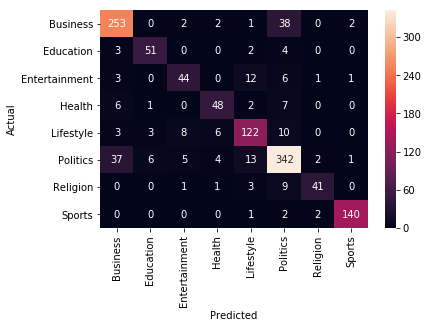

In [23]:
# creating the confusion matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=Label_class_df.Class.values, yticklabels=Label_class_df.Class.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [24]:
print(classification_report(y_test, y_pred,target_names= Label_class_df.Class.values ))


               precision    recall  f1-score   support

     Business       0.83      0.85      0.84       298
    Education       0.84      0.85      0.84        60
Entertainment       0.73      0.66      0.69        67
       Health       0.79      0.75      0.77        64
    Lifestyle       0.78      0.80      0.79       152
     Politics       0.82      0.83      0.83       410
     Religion       0.89      0.75      0.81        55
       Sports       0.97      0.97      0.97       145

     accuracy                           0.83      1251
    macro avg       0.83      0.81      0.82      1251
 weighted avg       0.83      0.83      0.83      1251



In [25]:
# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the dat
# cv=10 for 10 folds
# scoring='accuracy' for evaluation metric - althought they are many
scores = cross_val_score(model,features_df, cleanPosts['Y'], cv=10, scoring='accuracy')
print(scores)

[0.82006369 0.81180223 0.7814992  0.79744817 0.8245614  0.86421725
 0.86858974 0.81730769 0.82182986 0.77813505]


In [27]:
print('The Cross-validation score is {}'.format(scores.mean()))

The Cross-validation score is 0.818545429111504
